In [ ]:
%matplotlib inline


# Compute coherence in source space using a MNE inverse solution


This examples computes the coherence between a seed in the left
auditory cortex and the rest of the brain based on single-trial
MNE-dSPM inverse solutions.




In [ ]:
#NOT USED AS OF NOW!!!!!!!!!!



# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#
# License: BSD (3-clause)

import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import (apply_inverse, apply_inverse_epochs,
                              read_inverse_operator)
from mne.connectivity import seed_target_indices, spectral_connectivity

print(__doc__)

data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
label_name_lh = 'Aud-lh'
fname_label_lh = data_path + '/MEG/sample/labels/%s.label' % label_name_lh

event_id, tmin, tmax = 1, -0.2, 0.5
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Load data.
inverse_operator = read_inverse_operator(fname_inv)
label_lh = mne.read_label(fname_label_lh)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Add a bad channel.
raw.info['bads'] += ['MEG 2443']

# pick MEG channels.
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

# Read epochs.
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0),
                    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6))

# First, we find the most active vertex in the left auditory cortex, which
# we will later use as seed for the connectivity computation.
snr = 3.0
lambda2 = 1.0 / snr ** 2
evoked = epochs.average()
stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                    pick_ori="normal")

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label_lh)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data ** 2, axis=1)
seed_vertno = stc_label.vertices[0][np.argmax(src_pow)]
seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  # index in orig stc

# Generate index parameter for seed-based connectivity analysis.
n_sources = stc.data.shape[0]
indices = seed_target_indices([seed_idx], np.arange(n_sources))

# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list. This allows us so to
# compute the coherence without having to keep all source estimates in memory.

snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

# Now we are ready to compute the coherence in the alpha and beta band.
# fmin and fmax specify the lower and upper freq. for each band, resp.
fmin = (8., 13.)
fmax = (13., 30.)
sfreq = raw.info['sfreq']  # the sampling frequency

# Now we compute connectivity. To speed things up, we use 2 parallel jobs
# and use mode='fourier', which uses a FFT with a Hanning window
# to compute the spectra (instead of multitaper estimation, which has a
# lower variance but is slower). By using faverage=True, we directly
# average the coherence in the alpha and beta band, i.e., we will only
# get 2 frequency bins.
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    stcs, method='coh', mode='fourier', indices=indices,
    sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])

# Generate a SourceEstimate with the coherence. This is simple since we
# used a single seed. For more than one seeds we would have to split coh.
# Note: We use a hack to save the frequency axis as time.
tmin = np.mean(freqs[0])
tstep = np.mean(freqs[1]) - tmin
coh_stc = mne.SourceEstimate(coh, vertices=stc.vertices, tmin=1e-3 * tmin,
                             tstep=1e-3 * tstep, subject='sample')

# Now we can visualize the coherence using the plot method.
brain = coh_stc.plot('sample', 'inflated', 'both',
                     time_label='Coherence %0.1f Hz',
                     subjects_dir=subjects_dir,
                     clim=dict(kind='value', lims=(0.25, 0.4, 0.65)))
brain.show_view('lateral')

In [5]:
#NOT USED AS OF NOW!!!!!!!!!!

import mne  
raw = mne.io.read_raw_edf('Testdata.bdf')  # load data  
#raw.info['bads'] = ['MEG 2443', 'EEG 053']  # mark bad channels  
raw.load_data(raw)
raw.filter(l_freq=None, h_freq=40.0)  # low-pass filter  
#events = mne.find_events(raw, 'STI014')  # extract events and epoch data 
#epochs = mne.Epochs(raw, events, event_id=1, tmin=-0.2, tmax=0.5,  reject=dict(grad=4000e-13, mag=4e-12, eog=150e-6))  
evoked = epochs.average()  # compute evoked  
evoked.plot()  # butterfly plot the evoked data 
cov = mne.compute_covariance(epochs, tmax=0, method='shrunk')  
fwd = mne.read_forward_solution(fwd_fname, surf_ori=True)  
inv = mne.minimum_norm.make_inverse_operator(  
    raw.info, fwd, cov, loose=0.2)  # compute inverse operator 
stc = mne.minimum_norm.apply_inverse(  
    evoked, inv, lambda2=1. / 9., method='dSPM')  # apply it 
stc_fs = stc.morph('fsaverage')  # morph to fsaverage 
stc_fs.plot()  # plot source data on fsaverage's brain 

Extracting edf Parameters from Testdata.bdf...
Setting channel info structure...
Creating Raw.info structure...
Ready.


TypeError: Level not an integer or a valid string: <RawEDF  |  Testdata.bdf, n_channels x n_times : 65 x 1140736 (557.0 sec), ~135 kB, data not loaded>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.viz import circular_layout, plot_connectivity_circle
from mne.minimum_norm import (apply_inverse, apply_inverse_epochs,
                              read_inverse_operator)
from mne.connectivity import seed_target_indices, spectral_connectivity
from mne.preprocessing import run_ica

In [24]:


raw = mne.io.read_raw_eeglab('Exp1_annotated.set')  # load data  
events=mne.find_events(raw)
raw= raw.drop_channels()
#events = mne.read_events('Experiment 1_Tu18_7_11_12_annotations.txt')
#epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6))
ica=run_ica(raw, n_components=1, max_pca_components=63, n_pca_components=63, noise_cov=None, 
    random_state=None, picks=None, start=None, stop=None, start_find=None, stop_find=None, 
    ecg_ch=None, ecg_criterion=0.1, eog_ch=None, 
    eog_criterion=0.1, skew_criterion=-1, kurt_criterion=-1, var_criterion=0, add_nodes=None, verbose=None)



Reading Exp1_annotated.fdt
38 events found
Events id: [   7    8    9   15  131  132  133  134  136  137  139  960  991 1310 1311
 9100 9115]
Fitting ICA to data using 63 channels. 
Please be patient, this may take some time
Selection by number: 1 components
<ICA  |  raw data decomposition, fit (fastica): 4814848 samples, 1 components, channels used: "eeg">
    Now searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    0, 0, 0
    Removing duplicate indices...
Ready.


In [51]:
label_names = raw.ch_names
#label_names.remove('STI 014')
label_names.remove('2-A5')
print label_names

[u'1-A1', u'1-A2', u'1-A3', u'1-A4', u'1-A6', u'1-A7', u'1-A8', u'1-A9', u'1-A10', u'1-A11', u'1-A12', u'1-A13', u'1-A14', u'1-A15', u'1-A16', u'1-A17', u'1-A18', u'1-A19', u'1-A20', u'1-A21', u'1-A22', u'1-A23', u'1-A24', u'1-A25', u'1-A26', u'1-A27', u'1-A28', u'1-A29', u'1-A30', u'1-A31', u'1-A32', u'2-A1', u'2-A2', u'2-A3', u'2-A4', u'2-A6', u'2-A7', u'2-A8', u'2-A9', u'2-A10', u'2-A11', u'2-A12', u'2-A13', u'2-A14', u'2-A15', u'2-A16', u'2-A17', u'2-A18', u'2-A19', u'2-A20', u'2-A21', u'2-A22', u'2-A23', u'2-A24', u'2-A25', u'2-A26', u'2-A27', u'2-A28', u'2-A29', u'2-A30', u'2-A31', u'2-A32']


In [2]:
from mne.preprocessing import ICA

ica.save("exp1-ica.fif")

NameError: name 'ica' is not defined

In [4]:

#rest epochs
eog=mne.Epochs(raw, events, 7, 0, 20, baseline=(None, 0))
emg=mne.Epochs(raw, events, 8, 0, 20, baseline=(None, 0))
noise=mne.epochs.concatenate_epochs([eog,emg])
rest = mne.Epochs(raw, events, 9, 0, 15, baseline=(None, 0))

"""buf1= mne.Epochs(raw, events, 960, 0, 15 )
buf2= mne.Epochs(raw, events, 960, 15, 30 )
buf3= mne.Epochs(raw, events, 960, 30, 45 )
buf4= mne.Epochs(raw, events, 960, 45, 60)
rest1=mne.epochs.concatenate_epochs([buf1,buf2,buf3,buf4])"""
rest1= mne.Epochs(raw, events, 960, 0, 60 )
rest2= mne.Epochs(raw, events, 9115, 0, 115, baseline=(None, 0))
rest3= mne.Epochs(raw, events, 9100, 0, 100, baseline=(None, 0))
rest4= mne.Epochs(raw, events, 991, 0, 91, baseline=(None, 0))
r=[rest,rest1,rest2,rest3,rest4]
stim1 = mne.Epochs(raw, events, 131, 0, 144, baseline=(None, 0))
stim2 = mne.Epochs(raw, events, 132, 0, 103, baseline=(None, 0))
stim3 = mne.Epochs(raw, events, 133, 0, 119, baseline=(None, 0))
stim4 = mne.Epochs(raw, events, 134, 0, 171, baseline=(None, 0))

stim5 = mne.Epochs(raw, events, 136, 0, 94, baseline=(None, 0))
stim6 = mne.Epochs(raw, events, 137, 0, 279, baseline=(None, 0))

stim7 = mne.Epochs(raw, events, 139, 0, 180, baseline=(None, 0))
stim8 = mne.Epochs(raw, events, 1310, 0, 107, baseline=(None, 0))
stim9 = mne.Epochs(raw, events, 1311, 0, 286, baseline=(None, 0))
s=[stim1,stim2,stim3,stim4,stim5,stim6,stim7,stim8,stim9]



1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
Loading data for 1 events and 40961 original time points ...
0 bad epochs dropped
Loading data for 1 events and 40961 original time points ...
0 bad epochs dropped
2 matching events found
0 bad epochs dropped
8 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
1 matching events found
0 projection items activa

In [52]:
#rest epochs
"""raw.info['bads'] += ['STI 014']
picks_meg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')"""
#raw.drop_channels(['STI 014'])

eog=mne.Epochs(raw, events, 7, 0, 20, baseline=(None, 0))
emg=mne.Epochs(raw, events, 8, 0, 20, baseline=(None, 0))
noise=mne.epochs.concatenate_epochs([eog,emg])
rest = mne.Epochs(raw, events, 9, 0, 15, baseline=(None, 0))

rest1= mne.Epochs(raw, events, 960, 0, 40 )
#buf2= mne.Epochs(raw, events, 960, 15, 30 )
#buf3= mne.Epochs(raw, events, 960, 30, 45 )
#buf4= mne.Epochs(raw, events, 960, 45, 60)
#rest1=mne.epochs.concatenate_epochs([buf1,buf2,buf3,buf4])
#rest1= mne.Epochs(raw, events, 960, 0, 60 )

rest2= mne.Epochs(raw, events, 9115, 0, 40, baseline=(None, 0))
rest3= mne.Epochs(raw, events, 9100, 0, 40, baseline=(None, 0))
rest4= mne.Epochs(raw, events, 991, 0, 40, baseline=(None, 0))
rest=mne.epochs.concatenate_epochs([rest1,rest2,rest3,rest4])


stim1 = mne.Epochs(raw, events, 131, 0, 40, baseline=(None, 0))
stim2 = mne.Epochs(raw, events, 132, 0, 40, baseline=(None, 0))
stim3 = mne.Epochs(raw, events, 133, 0, 40, baseline=(None, 0))
stim4 = mne.Epochs(raw, events, 134, 0, 40, baseline=(None, 0))

stim5 = mne.Epochs(raw, events, 136, 0, 40, baseline=(None, 0))
stim6 = mne.Epochs(raw, events, 137, 0, 40, baseline=(None, 0))

stim7 = mne.Epochs(raw, events, 139, 0, 40, baseline=(None, 0))
stim8 = mne.Epochs(raw, events, 1310, 0, 40, baseline=(None, 0))
stim9 = mne.Epochs(raw, events, 1311, 0, 40, baseline=(None, 0))
stim=mne.epochs.concatenate_epochs([stim1,stim2,stim3,stim4,stim5,stim6,stim7,stim8,stim9])



1 matching events found
0 projection items activated
1 matching events found
0 projection items activated
Loading data for 1 events and 40961 original time points ...


RuntimeError: bad channel(s) ['STI 014', 'STI 014', 'STI 014', 'STI 014', 'STI 014', 'STI 014', 'STI 014', 'STI 014', 'STI 014'] marked do not exist in info

In [53]:
print coh

[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.54482245]
  [ 0.        ]
  [ 0.        ]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.59788942]
  [ 0.59942523]
  [ 0.        ]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 ..., 
 [[ 0.55281027]
  [ 0.57215462]
  [ 0.55956979]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.55948653]
  [ 0.5459438 ]
  [ 0.58217638]
  ..., 
  [ 0.5435354 ]
  [ 0.        ]
  [ 0.        ]]

 [[ 1.        ]
  [ 1.        ]
  [ 1.        ]
  ..., 
  [ 1.        ]
  [ 0.99999999]
  [ 0.        ]]]


In [56]:
coh1, freqs1, times, n_epochs, n_tapers = spectral_connectivity(rest, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=False,block_size=120000, n_jobs=24)


conmat1 = coh1[:, :, 0]
plot_connectivity_circle(conmat1, label_names, n_lines=300,linewidth=.5,title='All-to-All Connectivity')

coh2, freqs2, times, n_epochs, n_tapers = spectral_connectivity(stim, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=False,block_size=120000, n_jobs=24)

conmat2 = coh2[:, :, 0]
plot_connectivity_circle(conmat2, label_names, n_lines=300,linewidth=.5,title='All-to-All Connectivity')

Connectivity computation...
    computing connectivity for 2016 connections
    using t=0.000s..40.000s for estimation (81921 points)
    frequencies: 0.3Hz..48.9Hz (178 points)
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..4


[Parallel(n_jobs=24)]: Done   2 out of   4 | elapsed:    4.6s remaining:    4.6s


    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=24)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=24)]: Done   4 out of   4 | elapsed:    5.5s finished


ValueError: con has to be 1D or a square matrix

Loading data for 8 events and 30721 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    9.3s
[Parallel(n_jobs=16)]: Done  63 out of  78 | elapsed:   11.9s remaining:    2.8s
[Parallel(n_jobs=16)]: Done  78 out of  78 | elapsed:   13.1s finished


No baseline correction applied


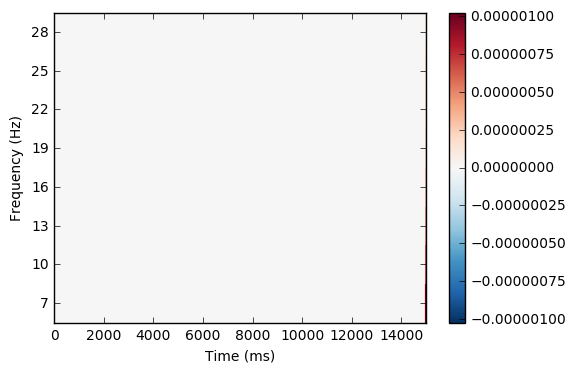

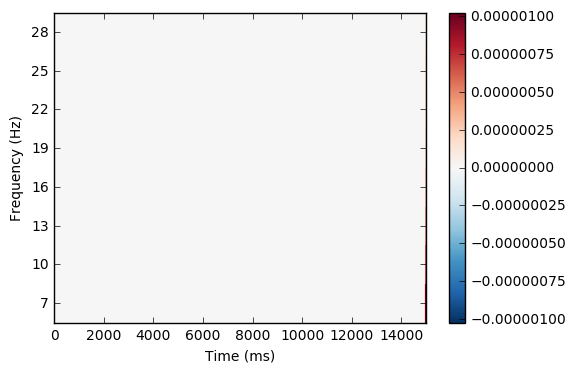

In [5]:
import numpy as np  # noqa
n_cycles = 2  # number of cycles in Morlet wavelet
freqs = np.arange(7, 30, 3)  # frequencies of interest
from mne.time_frequency import tfr_morlet  # noqa
power, itc = tfr_morlet(rest, freqs=freqs, n_cycles=n_cycles,
                        return_itc=True, decim=3, n_jobs=16)
power.plot([power.ch_names.index('1-A32')])

No baseline correction applied


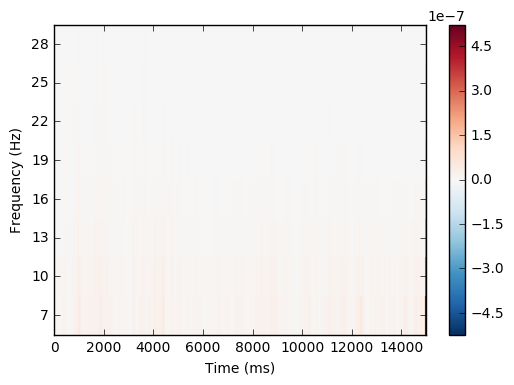

No baseline correction applied


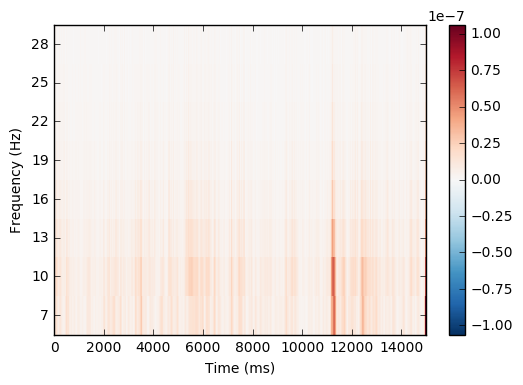

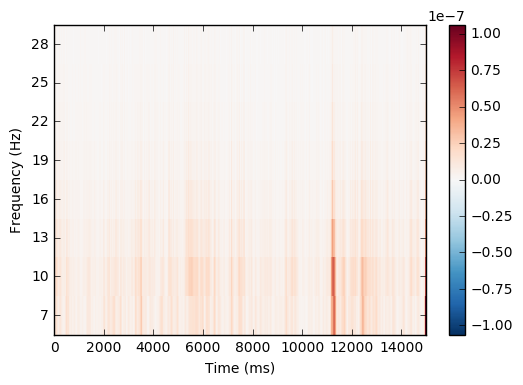

In [16]:
power.plot([power.ch_names.index('1-A20')])
power.plot([power.ch_names.index('2-A20')])

Loading data for 8 events and 30721 original time points ...


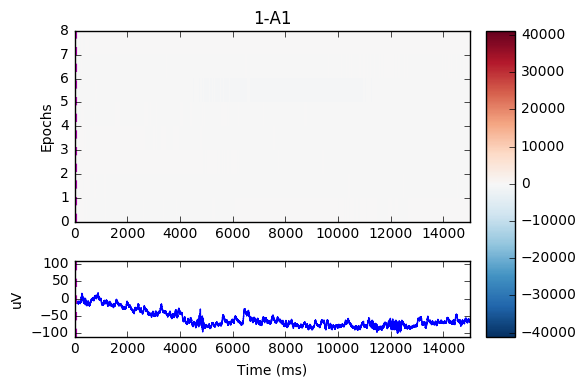

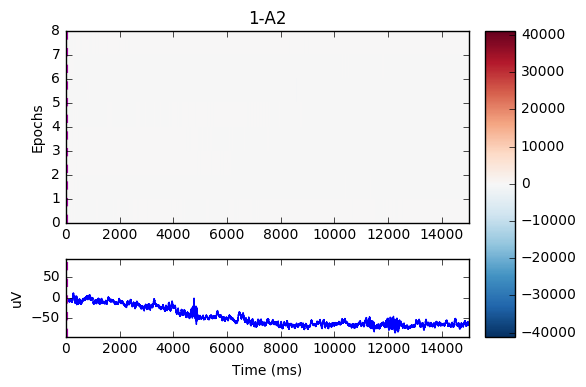

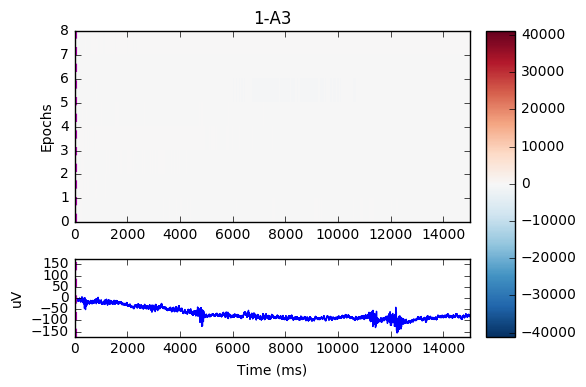

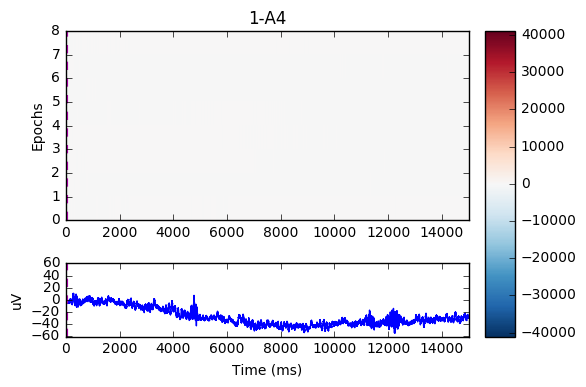

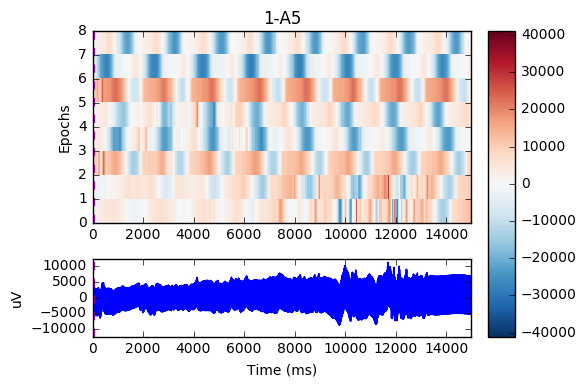

In [17]:
rest.plot_image()

7


NameError: name 'con' is not defined

Connectivity computation...
    computing connectivity for 2080 connections
    using t=0.000s..60.000s for estimation (122881 points)
    frequencies: 0.2Hz..48.9Hz (267 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..1
    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:   31.6s finished


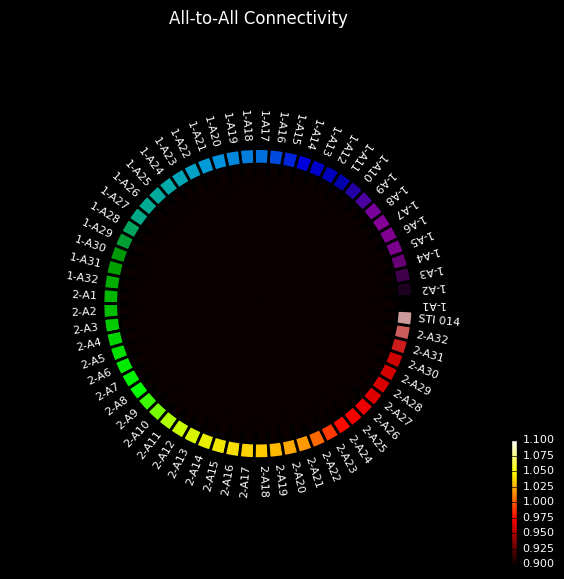

Connectivity computation...
    computing connectivity for 2080 connections
    using t=0.000s..115.000s for estimation (235521 points)
    frequencies: 0.1Hz..49.0Hz (512 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..1


[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:    3.8s finished


    assembling connectivity matrix
[Connectivity computation done]


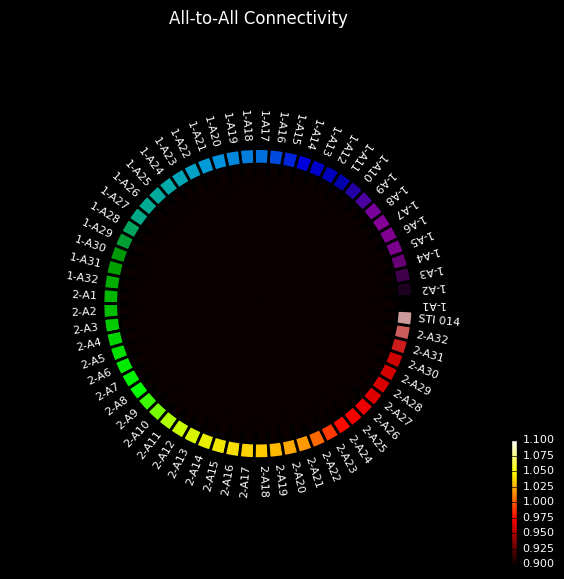

Connectivity computation...
    computing connectivity for 2080 connections
    using t=0.000s..100.000s for estimation (204801 points)
    frequencies: 0.1Hz..48.9Hz (445 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..1
    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:   18.2s finished


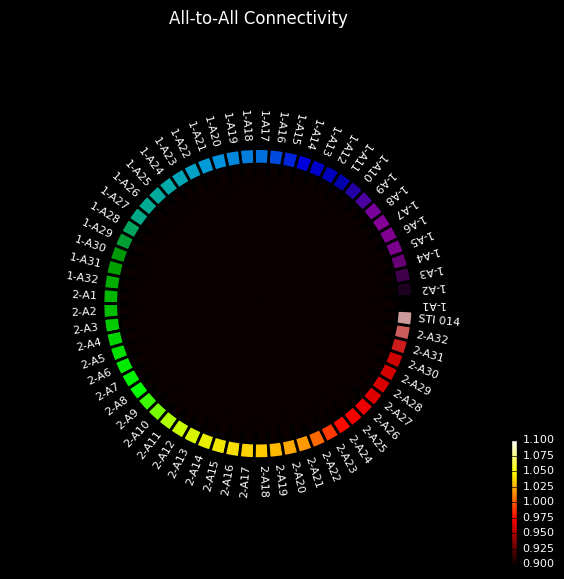

Connectivity computation...
    computing connectivity for 2080 connections
    using t=0.000s..91.000s for estimation (186369 points)
    frequencies: 0.1Hz..49.0Hz (405 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..1
    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=24)]: Done   1 out of   1 | elapsed:    4.6s finished


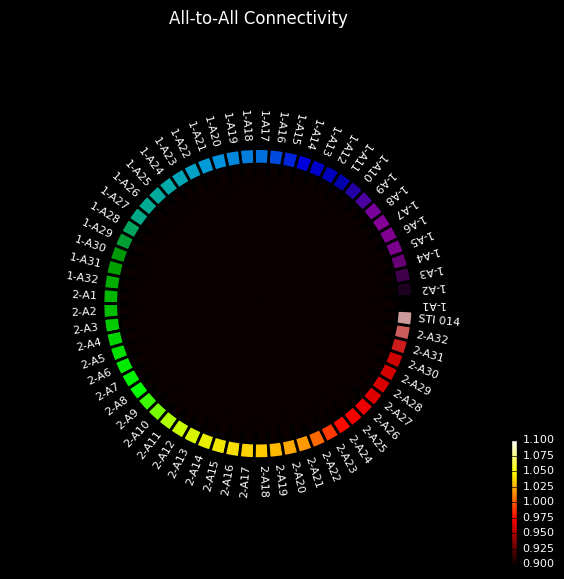

Connectivity computation...
    computing connectivity for 2080 connections
    using t=0.000s..15.000s for estimation (30721 points)
    frequencies: 0.7Hz..48.4Hz (66 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..8


[Parallel(n_jobs=24)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Parallel(n_jobs=24)]: Done   5 out of   8 | elapsed:    6.1s remaining:    3.6s


    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=24)]: Done   8 out of   8 | elapsed:    7.3s finished


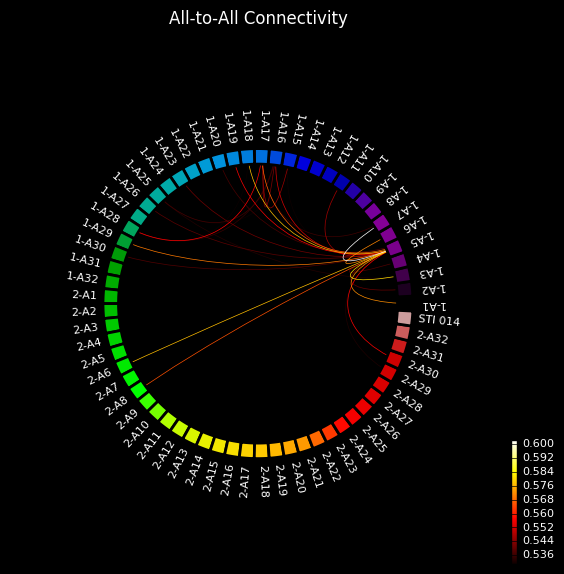

In [9]:
#evoked = epochs.average()  # compute evoked  
#evoked.plot()  # butterfly plot the evoked data 
#cov = mne.compute_covariance(epochs, tmax=0, method='shrunk')  
#ica = run_ica(epochs)

"""ica=run_ica(epochs, n_components=1, max_pca_components=50, n_pca_components=64, noise_cov=None, 
    random_state=None, picks=None, start=None, stop=None, start_find=None, stop_find=None, 
    ecg_ch=None, ecg_criterion=0.1, eog_ch=None, 
    eog_criterion=0.1, skew_criterion=-1, kurt_criterion=-1, var_criterion=0, add_nodes=None, verbose=None)

"""
coh_dump=[]
freqs_dump=[]
times_dump=[]

#snr = 3.0
#lambda2 = 1.0 / snr ** 2
#evoked = epochs.average()
#stc = apply_inverse(evoked, inverse_operator, lambda2, "dSPM",pick_ori="normal")
    
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest1, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=True,block_size=120000, n_jobs=24)
coh_dump.extend(coh)
freqs_dump.extend(freqs)
times_dump.extend(times)

conmat = coh[:, :, 0]
plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')

coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest2, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=True,block_size=120000, n_jobs=24)
coh_dump.extend(coh)
freqs_dump.extend(freqs)
times_dump.extend(times)
conmat = coh[:, :, 0]
plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')

coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest3, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=True,block_size=120000, n_jobs=24)
coh_dump.extend(coh)
freqs_dump.extend(freqs)
times_dump.extend(times)
conmat = coh[:, :, 0]
plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')

coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest4, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=True,block_size=120000, n_jobs=24)
coh_dump.extend(coh)
freqs_dump.extend(freqs)
times_dump.extend(times)
conmat = coh[:, :, 0]
plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')

coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest, method='wpli', mode='fourier', fmax=49,fskip=10, faverage=True,block_size=120000, n_jobs=24)
coh_dump.extend(coh)
freqs_dump.extend(freqs)
times_dump.extend(times)
conmat = coh[:, :, 0]
plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')


coh_rest=coh_dump
freqs_rest=freqs_dump
times_rest=times_dump
coh_dump=[]
freqs_rest=[]




In [12]:
cwt_frequencies = np.arange(1, 49, 1)
cwt_n_cycles = cwt_frequencies / 7.
#con, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest, method='wpli', mode='fourier', tmin=5, tmax=10,fmax=49, fskip=10,faverage=False,block_size=120000, n_jobs=16)
"""for i in range (0, len(freqs)):
    print('Frequencies in Hz over which coherence was averaged for')
    print(freqs[i])"""

print coh



[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.4486727 ]
  [ 0.        ]
  [ 0.        ]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.42898006]
  [ 0.44314943]
  [ 0.        ]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 ..., 
 [[ 0.38345197]
  [ 0.39897774]
  [ 0.37146843]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.43368905]
  [ 0.45874146]
  [ 0.43681346]
  ..., 
  [ 0.42389035]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.31972667]
  [ 0.34508217]
  [ 0.33323059]
  ..., 
  [ 0.41133502]
  [ 0.40822111]
  [ 0.        ]]]


In [61]:
print con[5]


print con[10]



print con[78]


[[ 0.64341984  0.60620198  0.93032537 ...,  0.24333598  0.21062147
   0.48684718]
 [ 0.69145188  0.43027148  0.57863768 ...,  0.1478157   0.13011305
   0.69947193]
 [ 0.7022852   0.45229952  0.78348017 ...,  0.88189514  0.47725989
   0.84322948]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[[ 0.62010475  0.3925811   0.6877273  ...,  0.40129644  0.06945775
   0.11025562]
 [ 0.7023004   0.32521541  0.13871909 ...,  0.0043709   0.35007128
   0.44029332]
 [ 0.71563147  0.23144209  0.03616086 ...,  0.04234427  0.42201125
   0.00714903]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[[ 0.  0.  0

2.19978517723
65
2.19978517723


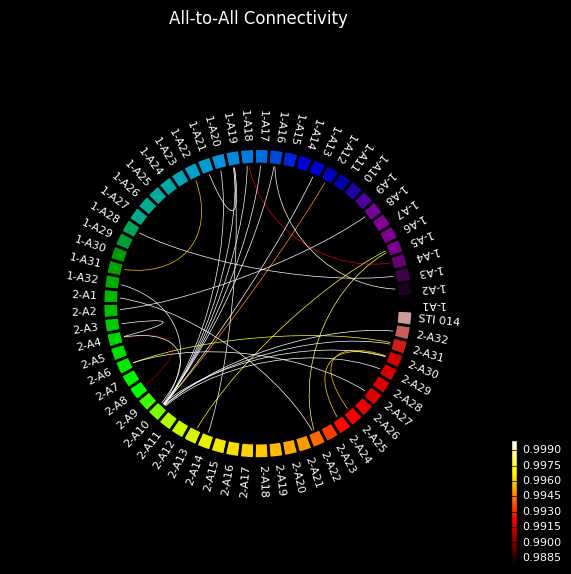

4.39957035446


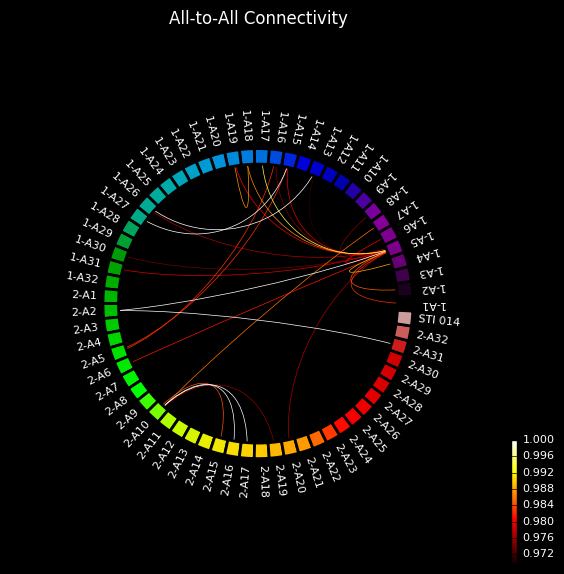

6.59935553169


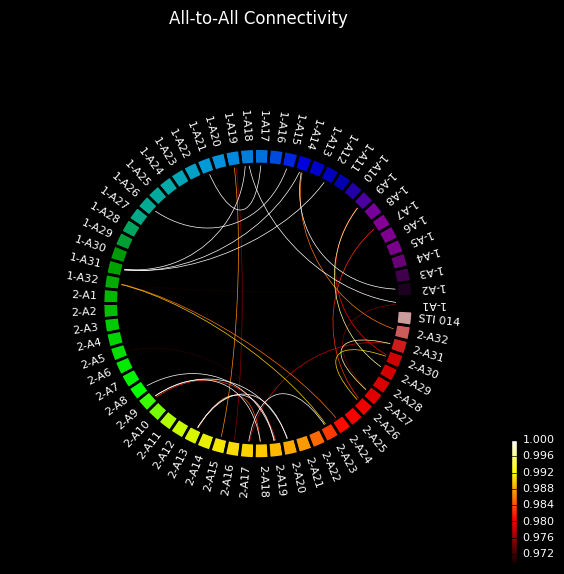

8.79914070892


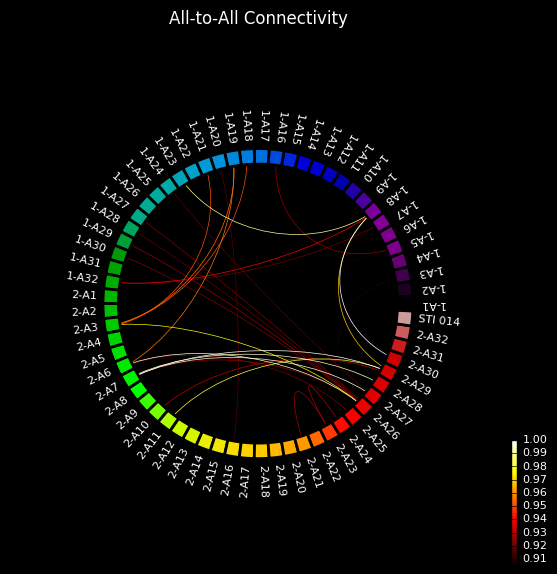

10.9989258861


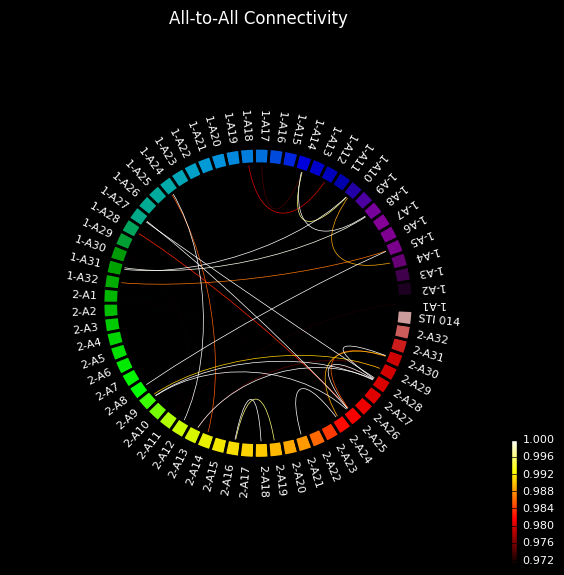

13.1987110634


C:\Users\Dominik\Anaconda2\lib\site-packages\mne\viz\circle.py:340: RuntimeWarning: invalid value encountered in divide
  con_val_scaled = (con - vmin) / vrange
C:\Users\Dominik\Anaconda2\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


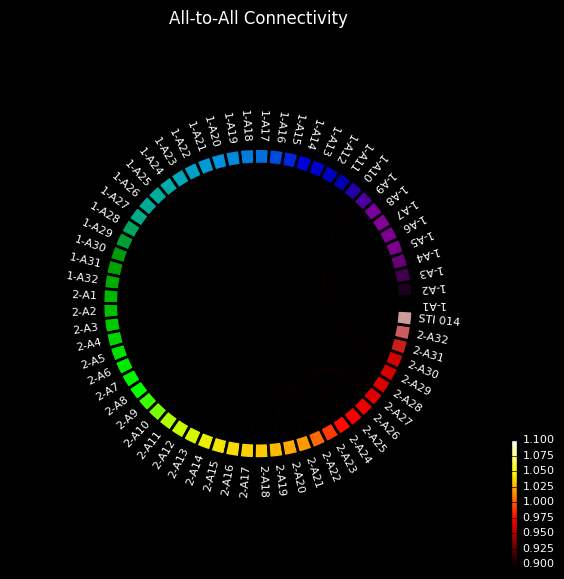

15.3984962406


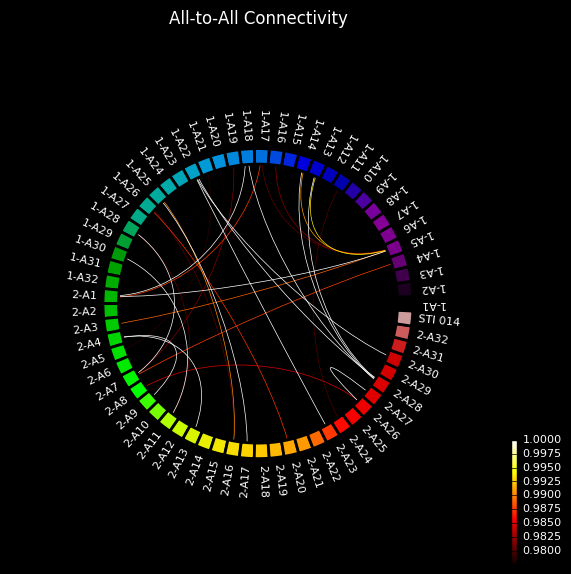

17.5982814178


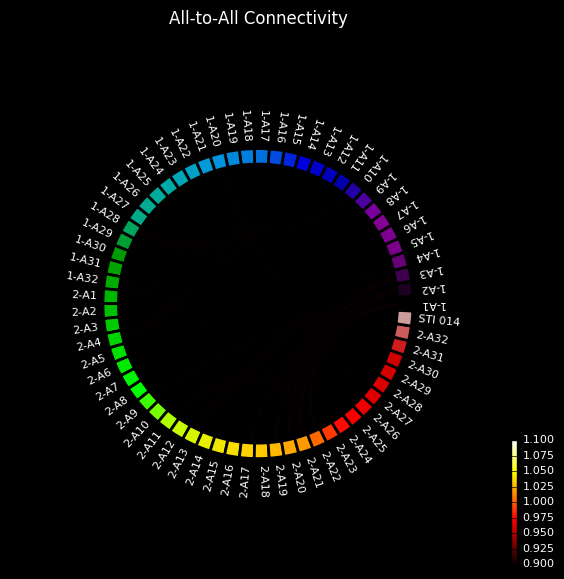

19.7980665951


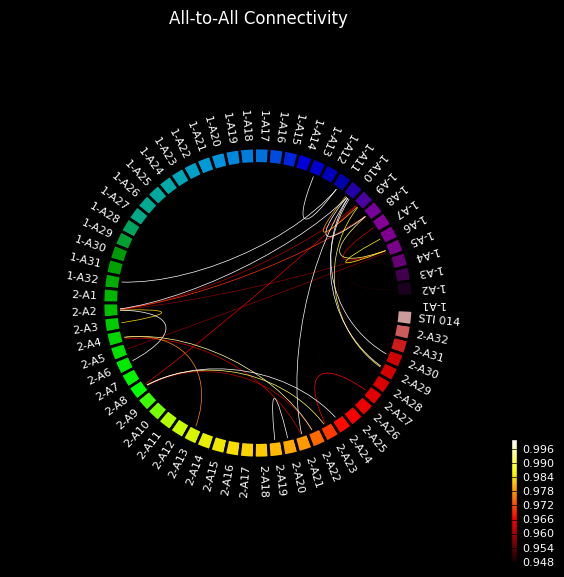

21.9978517723


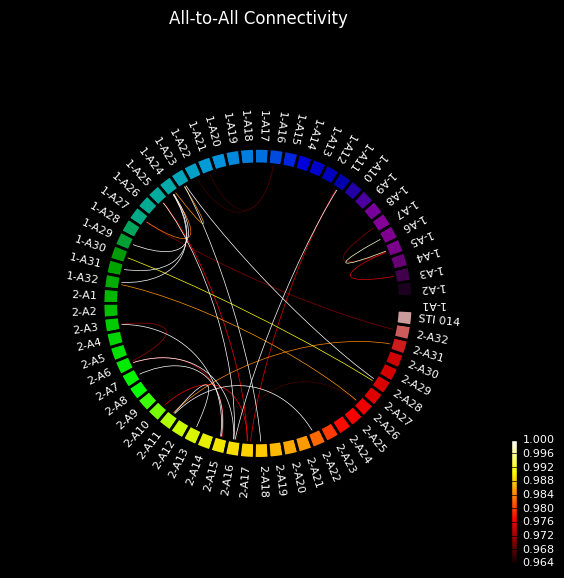

24.1976369495


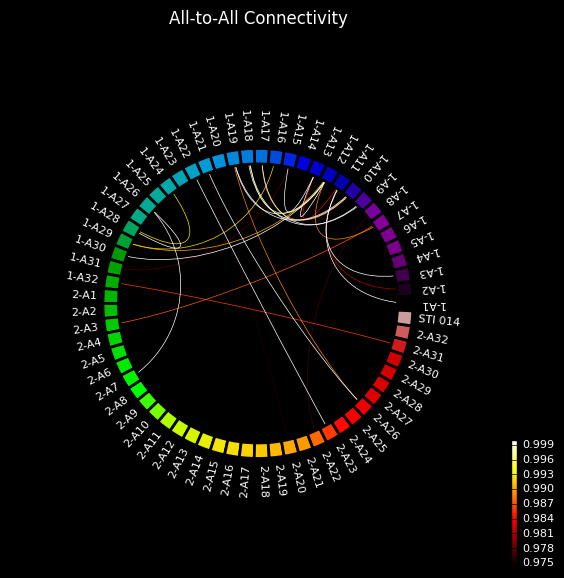

26.3974221267


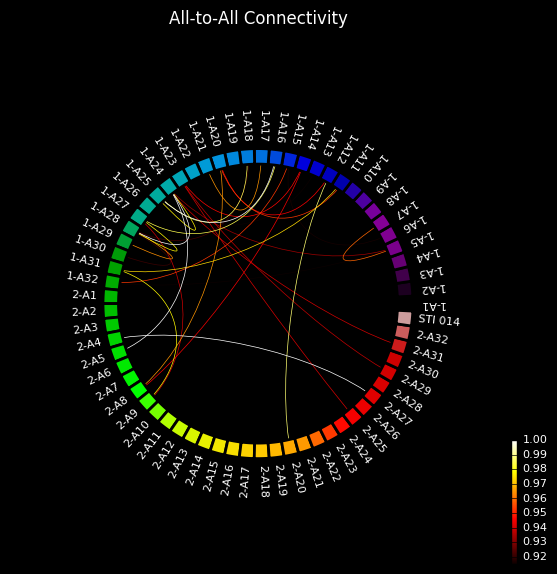

28.597207304


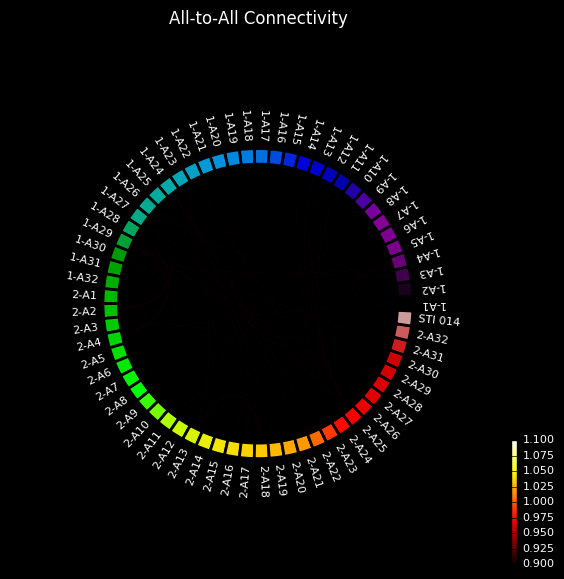

30.7969924812


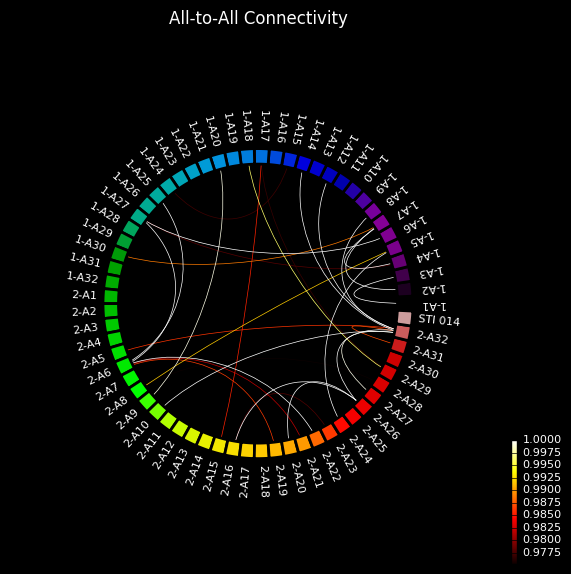

32.9967776584


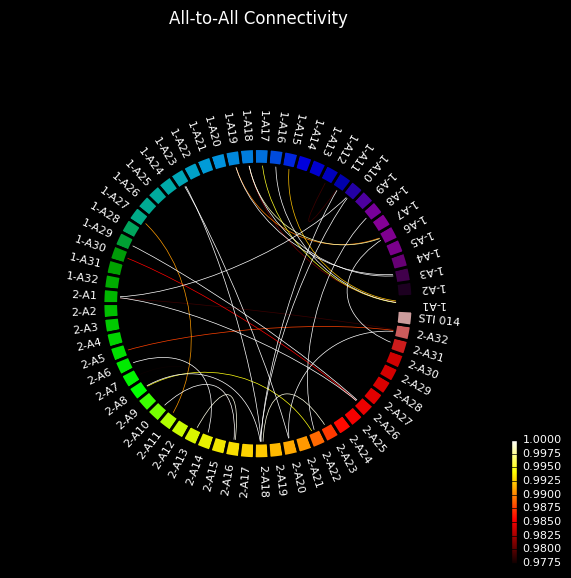

35.1965628357


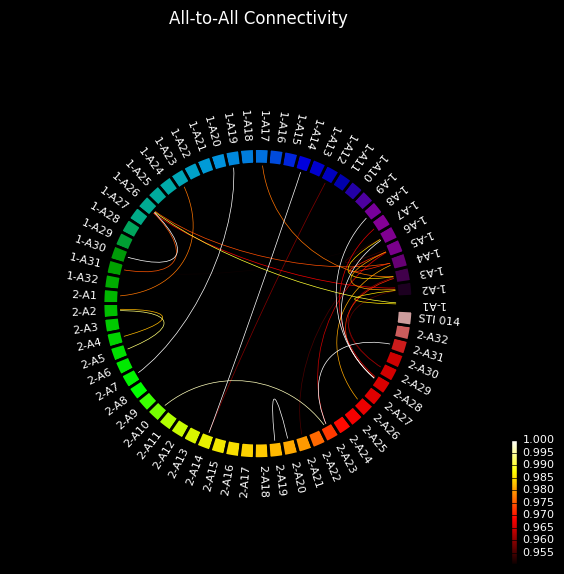

37.3963480129


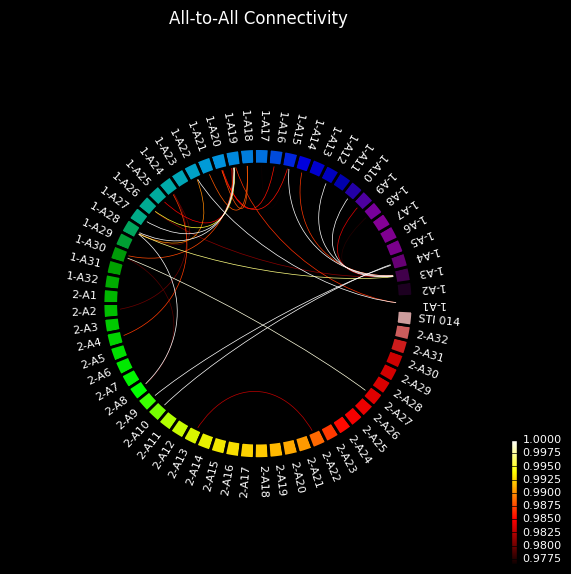

39.5961331901


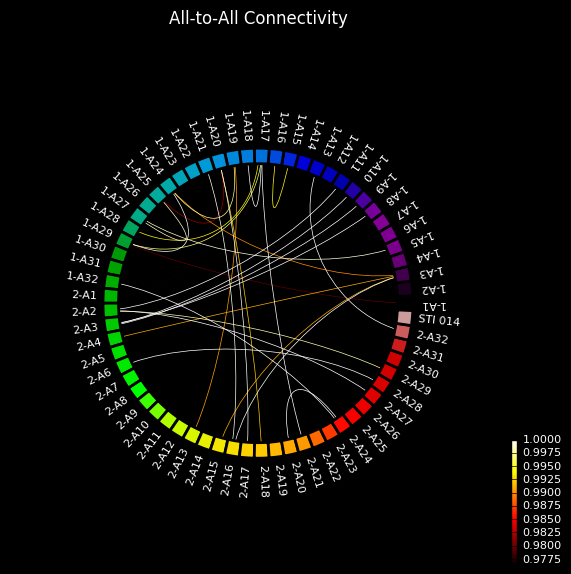

41.7959183673


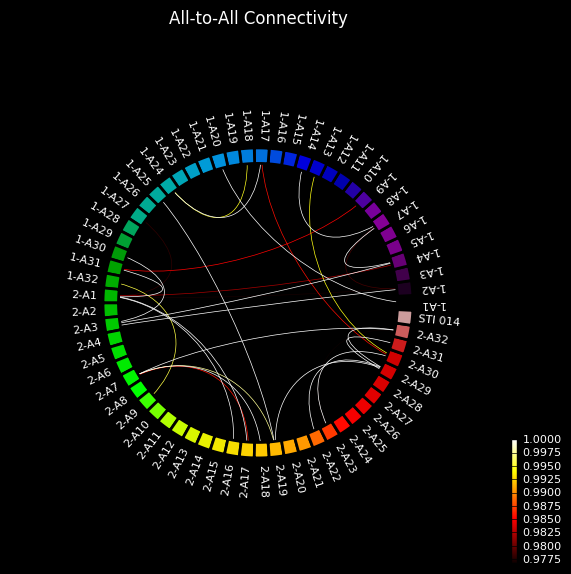

43.9957035446


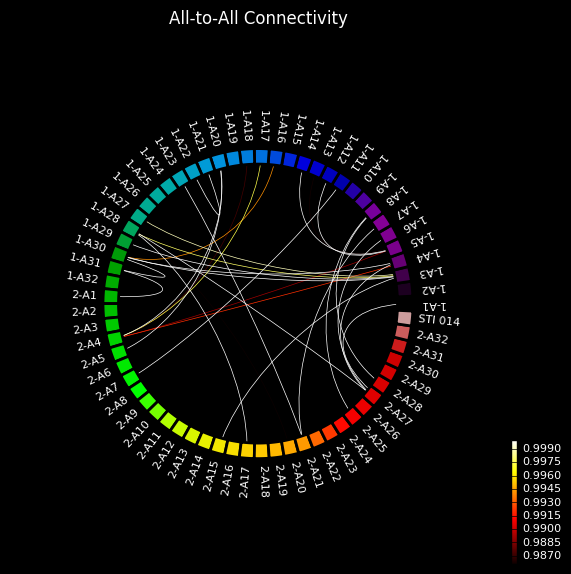

46.1954887218


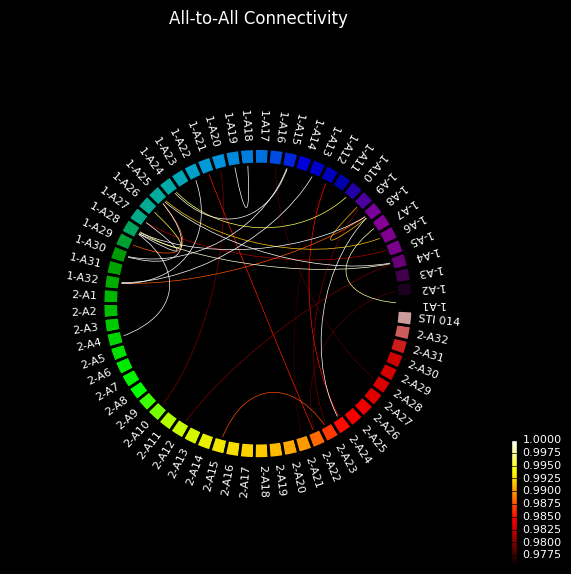

In [8]:
#testkram
label_names = rest1.ch_names

print freqs[0]
print len(con[:,:,:])

#con_f=con[:,:,f]
for i in range(0,21):
    conmat = con[:, :, i]
    print freqs[i]
    plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')

Connectivity computation...
    computing connectivity for 2080 connections
    using t=0.000s..15.000s for estimation (30721 points)
    frequencies: 0.7Hz..48.4Hz (66 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epochs 1..8


[Parallel(n_jobs=16)]: Done   3 out of   8 | elapsed:    3.2s remaining:    5.4s
[Parallel(n_jobs=16)]: Done   5 out of   8 | elapsed:    3.8s remaining:    2.2s


    assembling connectivity matrix
[Connectivity computation done]


[Parallel(n_jobs=16)]: Done   8 out of   8 | elapsed:    4.6s finished


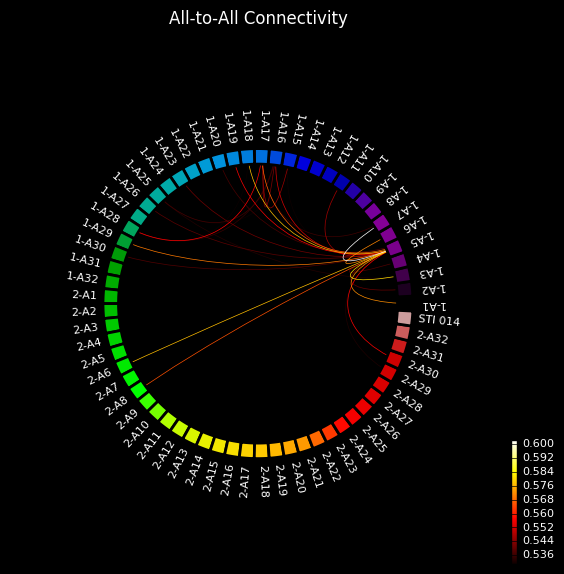

(<matplotlib.figure.Figure at 0x715630b8>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x712cd4e0>)

In [73]:
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest, method='wpli', mode='fourier', fmax=49, fskip=10,faverage=True,block_size=120000, n_jobs=16)

conmat = con[:, :, 0]

plot_connectivity_circle(conmat, label_names, n_lines=30,linewidth=.5,title='All-to-All Connectivity')

In [8]:
import matplotlib.pyplot as plt
n_rows, n_cols = con.shape[:2]
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
plt.suptitle('Between labels connectivity')
for i in range(n_rows):
    for j in range(i + 1):
        if i == j:
            axes[i, j].set_axis_off()
            continue

        axes[i, j].plot(freqs, con[i, j, :])
        axes[j, i].plot(freqs, con[i, j, :])

        if j == 0:
            axes[i, j].set_ylabel(names[i])
            axes[0, i].set_title(names[i])
        if i == (n_rows - 1):
            axes[i, j].set_xlabel(names[j])
        axes[i, j].set_xlim([fmin, fmax])
        axes[j, i].set_xlim([fmin, fmax])

        # Show band limits
        for f in [8, 12, 18, 35]:
            axes[i, j].axvline(f, color='k')
            axes[j, i].axvline(f, color='k')
plt.show()

KeyboardInterrupt: 

In [9]:
#TESTLINE!!!!!!!

coh_dump=[]
freqs_dump=[]
times_dump=[]
import time
#snr = 3.0
#lambda2 = 1.0 / snr ** 2
#evoked = epochs.average()
#stc = apply_inverse(evoked, inverse_operator, lambda2, "dSPM",pick_ori="normal")
timer=time.time()    
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(rest1, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=12)
coh_dump.extend(coh)
print (time.time()-timer)
freqs_dump.extend(freqs)
times_dump.extend(times)

Connectivity computation...
    computing connectivity for 3081 connections
    using t=0.000s..60.000s for estimation (122881 points)
    frequencies: 0.1Hz..49.0Hz (2936 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
34.7119998932


In [16]:
#TESTLINE!!!!!!!

layout = raw.set_montage("cap_32_layout_medium.jpg")  # use full layout

tfr = AverageTFR(rest.info, coh_rest, times, freqs_rest, len(epochs))
tfr.plot_topo(fig_facecolor='w', font_color='k', border='k')

TypeError: Montage must be a 'Montage' or 'DigMontage' instead of '<type 'str'>'.

In [11]:
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim1, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim2, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim3, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim4, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim5, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim6, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim7, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim8, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(stim9, method='wpli', mode='fourier', fmax=49, faverage=True, n_jobs=1)
coh_dump.extend(coh)
freqs_dump.extend(coh)
coh_stim=coh_dump
freqs_stim=freqs_dump

Connectivity computation...
    computing connectivity for 3081 connections
    using t=0.000s..144.000s for estimation (294913 points)
    frequencies: 0.0Hz..49.0Hz (7052 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 3081 connections
    using t=0.000s..103.000s for estimation (210945 points)
    frequencies: 0.0Hz..49.0Hz (5043 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: WPLI
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Connectivity computation...
    computing connectivity for 3081 connections
    using t=0.000s..119.000s f